Objective:
The goal is to rebalance class distributions by generating synthetic samples for underrepresented groups in Adult dataset, specifically focusing on women with positive income outcomes (income >50K) and whose marital status is Never-Married.

Bias Mitigation Strategy: Synthetic Data Generation

Applied synthetic data generation to rebalance the dataset by increasing the representation of women with high income and who have never been married through synthetic samples.

Steps:
- Filtered the dataset to extract women with positive income outcomes and martial status never married.
- Generated synthetic samples for this underrepresented group using the Clearbox AI tool.
- Saved the synthetic dataset and combined it with the original dataset to create a more balanced dataset.

In [1]:
pip install aif360

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.model_selection import train_test_split
from clearbox_engine import Dataset, Preprocessor, TabularEngine, LabeledSynthesizer
from aif360.metrics import ClassificationMetric
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import copy
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(1)


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
/usr/local/lib/python3.9/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /usr/local/lib/python3.9/site-packages/clearbox_engine/metrics/privacy/gower_matrix_c.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /usr/local/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.pyxbld/temp.linux-x86_64-3.9/usr/local/lib/python3.9/site-packages/clearbox_engine/metrics/priv

In [3]:
LICENSE_KEY = "licensekeyoverride2023@"

# Load Original Dataset
file_path = "https://raw.githubusercontent.com/gillus/Corso_MLOps/refs/heads/main/data"

train_dataset = Dataset.from_csv(
    os.path.join(file_path, "adult_training.csv"),
    target_column="income",
    regression=False
)

In [4]:
# Filter Data for Women with Positive Outcomes

# Extract features and labels
features_array = train_dataset.get_x()
labels_array = train_dataset.get_y()

# Convert features to DataFrame for processing
features_df = pd.DataFrame(features_array, columns=train_dataset.x_columns())

# Create a Boolean mask for women with positive outcomes
mask = (features_df["sex"] == "Female") & (features_df["marital_status"] == "Never-Married") & (labels_array == ">50K")
# Filter and combine features and labels using concat
filtered_features = features_df.loc[mask]
filtered_labels = pd.Series(labels_array).loc[mask].reset_index(drop=True)

# Concatenate features and labels
women_positive_df = pd.concat([filtered_features.reset_index(drop=True), filtered_labels.rename("income")], axis=1)

# Rebuild Dataset object #maybe i can avoid this step of building it and then converting it to a df and just skip to saving it to the csv, which by the way, again idk if i should do it or just do one csv file in the end
#ok yes i need to do it to pass it to the preprocessor, but again i can use the last df and not recreate it
women_positive_dataset = Dataset(
    data=women_positive_df,
    column_types=train_dataset.column_types,
    target_column="income",
    regression=train_dataset.regression,
)


In [5]:
# Save the DataFrame to a CSV file
#women_positive_df.to_csv("original_women_positive_dataset.csv", index=False)

#print("Dataset saved as women_positive_dataset.csv")



Dataset saved as women_positive_dataset.csv


In [5]:
# Preprocess Data

# Preprocessor initialization
preprocessor = Preprocessor(women_positive_dataset)

# Preprocess features
X_train_raw = women_positive_dataset.get_x() #original features
X_train = preprocessor.transform(X_train_raw) #transformed features

# Preprocess labels
if women_positive_dataset.regression:
    Y = women_positive_dataset.get_normalized_y()
else:
    Y = women_positive_dataset.get_one_hot_encoded_y()

# Train TabularEngine
engine = TabularEngine(
    license_key=LICENSE_KEY,
    layers_size=[50],
    x_shape=X_train[0].shape,
    y_shape=Y[0].shape,
    ordinal_feature_sizes=preprocessor.get_features_sizes()[0],
    categorical_feature_sizes=preprocessor.get_features_sizes()[1],
)
engine.fit(X_train, y_train_ds=Y, epochs=5, learning_rate=0.001)


/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (163). n_quantiles is set to n_samples.
  warnings.warn(
2025-01-15 11:47:25.238 | INFO     | __main__:<module>:17 - I'm the Sept 2024 engine!


Clearbox AI Engine: your license is valid.


Engine fitting in progress: 100%|██████████| 5/5 [00:05<00:00,  1.12s/epoch, Train loss:=5157.929]


In [6]:
# Generate Synthetic Data

synthesizer = LabeledSynthesizer(women_positive_dataset, engine)

num_synthetic_datasets = 18  # Number of synthetic datasets to generate
synthetic_dfs = []

# Generate multiple synthetic datasets
for i in range(num_synthetic_datasets):
    synthetic_df_i = synthesizer.generate(has_header=True)
    synthetic_dfs.append(synthetic_df_i)


/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (163). n_quantiles is set to n_samples.
  warnings.warn(


In [7]:
# Combine all synthetic datasets
synthetic_combined_df = pd.concat(synthetic_dfs, ignore_index=True)

# Save combined synthetic data
#synthetic_combined_df.to_csv("synthetic_women_positive_dataset_combined.csv", index=False)
print(f"Generated {num_synthetic_datasets} full synthetic datasets, saved as 'synthetic_women_positive_dataset_combined.csv'")


Generated 18 full synthetic datasets, saved as 'synthetic_women_positive_dataset_combined.csv'


In [8]:
# Prepare original dataset for fairness metrics
original_df = pd.DataFrame(features_array, columns=train_dataset.x_columns()) 
original_df["income"] = labels_array

# Map categorical columns to numeric values
original_df["sex"] = original_df["sex"].map({"Male": 1.0, "Female": 0.0})
original_df["income"] = original_df["income"].map({">50K": 1.0, "<=50K": 0.0})

# One-hot encode categorical variables for compatibility
categorical_columns = ["work_class", "education", "marital_status", "occupation", "relationship", "race", "native_country"]
original_df = pd.get_dummies(original_df, columns=categorical_columns)

# Convert the DataFrame to a BinaryLabelDataset
original_dataset = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=original_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)

# Define privileged and unprivileged groups
privileged_groups = [{'sex': 1.0}]  # Males
unprivileged_groups = [{'sex': 0.0}]  # Females

# Calculate fairness metrics for the original dataset
original_metric = BinaryLabelDatasetMetric(
    original_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Print fairness metrics for the original dataset
print("Fairness Metrics for Original Dataset:")
print("  Statistical Parity Difference:", original_metric.statistical_parity_difference())
print("  Disparate Impact:", original_metric.disparate_impact())

Fairness Metrics for Original Dataset:
  Statistical Parity Difference: -0.20015891077100018
  Disparate Impact: 0.36222035623624405


In [9]:
# Extract original dataset into a pandas DataFrame
original_df = pd.DataFrame(features_array, columns=train_dataset.x_columns())  #same as up but not one hot encoded in order to concatenate it with synthetic datasets
original_df["income"] = labels_array  # same as up

# Combine original and synthetic datasets
combined_df = pd.concat([original_df, synthetic_combined_df], ignore_index=True)

# One-hot encode categorical variables for the combined dataset
categorical_columns = [
    "work_class", "education", "marital_status", "occupation", 
    "relationship", "race", "native_country"
]
combined_df = pd.get_dummies(combined_df, columns=categorical_columns)

# Map 'sex' and 'income' to numeric values
combined_df["sex"] = combined_df["sex"].map({"Male": 1.0, "Female": 0.0})
combined_df["income"] = combined_df["income"].map({">50K": 1.0, "<=50K": 0.0})

# Define privileged and unprivileged groups
privileged_groups = [{'sex': 1.0}]  # Males
unprivileged_groups = [{'sex': 0.0}]  # Females

# Convert combined data to BinaryLabelDataset
combined_dataset = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=combined_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)

# Compute fairness metrics
metric = BinaryLabelDatasetMetric(
    combined_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Display fairness metrics
print("Fairness Metrics for Combined Dataset:")
print("  Statistical Parity Difference:", metric.statistical_parity_difference())
print("  Disparate Impact:", metric.disparate_impact())

Fairness Metrics for Combined Dataset:
  Statistical Parity Difference: 0.004344722990454075
  Disparate Impact: 1.0138438796975382


In [9]:
# Save combined original + synthetic data
#combined_df.to_csv("dataset_combined.csv", index=False)


In [10]:
# Load validation and test datasets
file_path = "https://raw.githubusercontent.com/gillus/Corso_MLOps/refs/heads/main/data"

orig_train_df = pd.read_csv(f"{file_path}/adult_training.csv")
orig_train_df = pd.get_dummies(orig_train_df, columns=["work_class", "education", "marital_status",
                                         "occupation", "relationship", "race", "native_country"])
orig_train_df["sex"] = orig_train_df["sex"].map({"Female": 0.0, "Male": 1.0})
orig_train_df["income"] = orig_train_df["income"].map({"<=50K": 0.0, ">50K": 1.0})
orig_train_df = orig_train_df.reindex(columns=combined_df.columns, fill_value=0)

# Validation dataset
val_df = pd.read_csv(f"{file_path}/adult_validation.csv")
val_df = pd.get_dummies(val_df, columns=["work_class", "education", "marital_status",
                                         "occupation", "relationship", "race", "native_country"])
val_df["sex"] = val_df["sex"].map({"Female": 0.0, "Male": 1.0})
val_df["income"] = val_df["income"].map({"<=50K": 0.0, ">50K": 1.0})
val_df = val_df.reindex(columns=combined_df.columns, fill_value=0)

# Test dataset
test_df = pd.read_csv(f"{file_path}/adult_test.csv")
test_df = pd.get_dummies(test_df, columns=["work_class", "education", "marital_status",
                                           "occupation", "relationship", "race", "native_country"])
test_df["sex"] = test_df["sex"].map({"Female": 0.0, "Male": 1.0})
test_df["income"] = test_df["income"].map({"<=50K": 0.0, ">50K": 1.0})
test_df = test_df.reindex(columns=combined_df.columns, fill_value=0)

# Convert to BinaryLabelDataset

train_transf = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=combined_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)

train = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=orig_train_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)

val = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=val_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)

test = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=test_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)

In [11]:
# Standardize the features
scaler = StandardScaler()
train.features = scaler.fit_transform(train.features)
val.features = scaler.transform(val.features)
test.features = scaler.transform(test.features)

In [12]:
# Ensure the classifier has a fixed random state and uses a deterministic solver
classifier = LogisticRegression(random_state=1, solver='liblinear', max_iter=1000)



In [13]:
# Train a classifier on original training data
classifier.fit(train.features, train.labels.ravel())

# Predict on validation set
val_scores = classifier.predict_proba(val.features)[:, 1] 

# Select best threshold for validation set
thresholds = np.arange(0.01, 1, 0.01)
val_balanced_accs = []

for threshold in thresholds:
    val_LR_predictions = (val_scores >= threshold).astype(int)

    val_with_LR_scores = copy.deepcopy(val)
    val_with_LR_scores.labels = val_LR_predictions.reshape(-1, 1)  # Update labels with predictions

    val_metric = ClassificationMetric(val, val_with_LR_scores,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
    balanced_acc = (val_metric.true_positive_rate() + val_metric.true_negative_rate()) / 2
    val_balanced_accs.append(balanced_acc)

best_index = np.argmax(val_balanced_accs)
best_threshold = thresholds[best_index]
best_balanced_acc = val_balanced_accs[best_index]

print(f"Best Threshold (validation): {best_threshold}")
print(f"Best Balanced Accuracy (validation): {best_balanced_acc}")

Best Threshold (validation): 0.21000000000000002
Best Balanced Accuracy (validation): 0.817569915996163


In [14]:
# Apply the best threshold to the test set
test_scores = classifier.predict_proba(test.features)[:, 1]
test_LR_predictions= (test_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_with_LR_scores = copy.deepcopy(test)
test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_metric = ClassificationMetric(test, test_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index (test): {theil_index}")

Balanced Accuracy (test): 0.8158929171377768
Statistical Parity Difference (test): -0.3658105610893654
Disparate Impact (test): 0.2957369481123719
Average Odds Difference (test): -0.22553133790350702
Equal Opportunity Difference (test): -0.18605974504097822
Theil Index (test): 0.07824140256940872


In [22]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

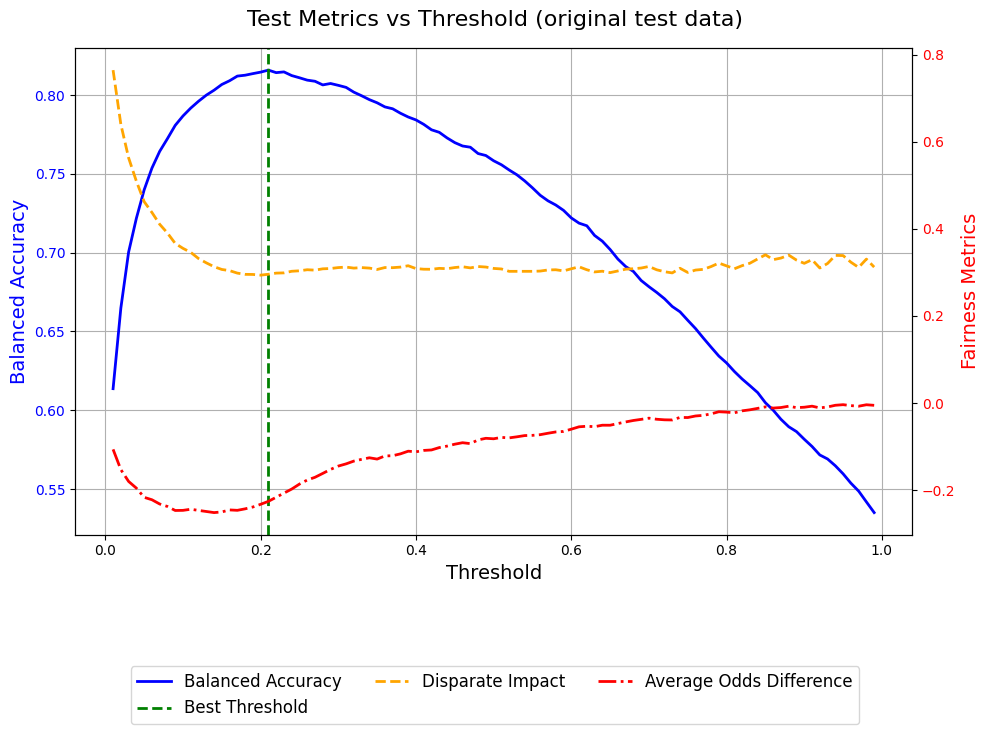

In [23]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [15]:
test_transf = test


In [16]:
classifier.fit(train_transf.features, train_transf.labels.ravel())


LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [17]:
# Apply the best threshold to the transf test set
test_transf_scores = classifier.predict_proba(test_transf.features)[:, 1]
test_transf_LR_predictions= (test_transf_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_transf_with_LR_scores = copy.deepcopy(test)
test_transf_with_LR_scores.labels = test_transf_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_transf_metric = ClassificationMetric(test, test_transf_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_transf_metric.true_positive_rate()
true_negative_rate = test_transf_metric.true_negative_rate()
balanced_accuracy_transf = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy_transf}")

# Statistical Parity Difference
statistical_parity_difference_transf = test_transf_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference_transf}")

# Disparate Impact
disparate_impact_transf = test_transf_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact_transf}")

# Average Odds Difference
average_odds_difference_transf = test_transf_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference_transf}")

# Equal Opportunity Difference
equal_opportunity_difference_transf = test_transf_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference_transf}")

# Theil Index
theil_index_transf = test_transf_metric.theil_index()
print(f"Theil Index (test): {theil_index_transf}")

Balanced Accuracy (test): 0.7568532445634911
Statistical Parity Difference (test): -0.3122209642945081
Disparate Impact (test): 0.4680737845712016
Average Odds Difference (test): -0.1853569097465311
Equal Opportunity Difference (test): -0.1339744226250036
Theil Index (test): 0.08817275945764023


In [18]:
# Plot Test Metrics Over Thresholds
test_transf_balanced_accs = []
test_transf_disp_impacts = []
test_transf_avg_odds_diffs = []

for threshold in thresholds:
    test_transf_predictions = (test_transf_scores >= threshold).astype(int)
    test_transf_with_scores = copy.deepcopy(test)
    test_transf_with_scores.labels = test_transf_predictions.reshape(-1, 1)

    test_transf_metric = ClassificationMetric(test, test_transf_with_scores, unprivileged_groups, privileged_groups)
    test_transf_balanced_accs.append((test_transf_metric.true_positive_rate() + test_transf_metric.true_negative_rate()) / 2)
    test_transf_disp_impacts.append(test_transf_metric.disparate_impact())
    test_transf_avg_odds_diffs.append(test_transf_metric.average_odds_difference())

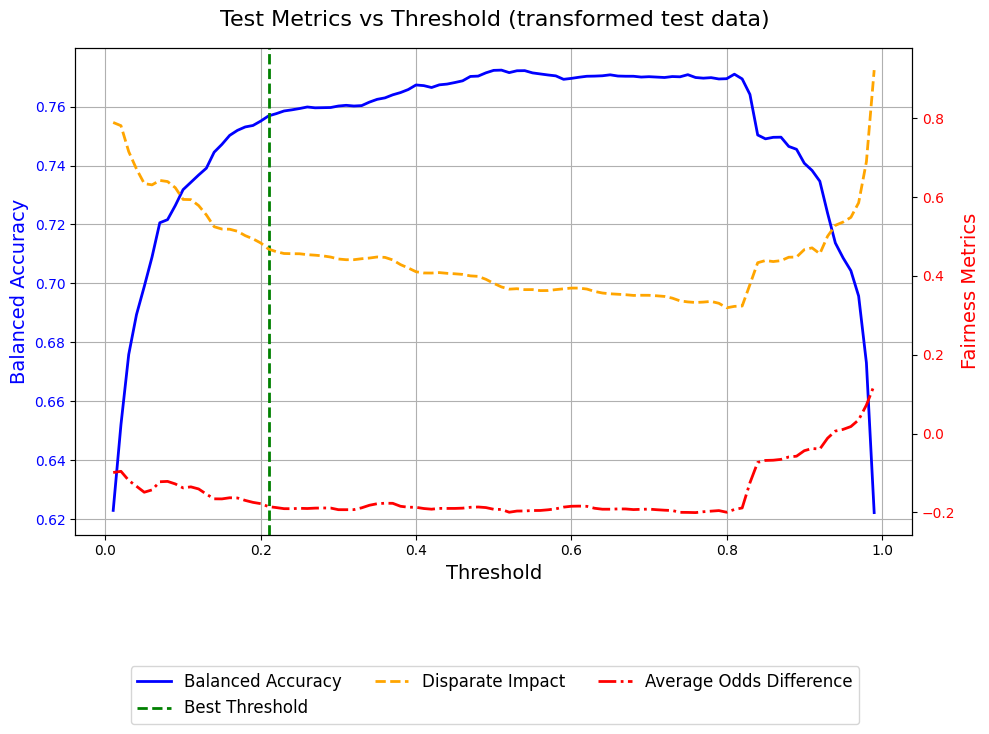

In [19]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_transf_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_transf_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_transf_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

#ax2.set_ylim(-0.05, 0.07) 
ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [20]:
# Organizing the metrics with actual calculated values
results_data = {
    "Dataset": [
        "Validation", "Validation", 
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)"
    ],
    "Stage": [
        "Best Threshold (Validation)", "Best Threshold (Validation)",
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold"
    ],
    "Metric": [
        "Threshold", "Balanced Accuracy",
        "Balanced Accuracy", "Balanced Accuracy", 
        "Statistical Parity Difference", "Statistical Parity Difference", 
        "Disparate Impact", "Disparate Impact",
        "Average Odds Difference", "Average Odds Difference",
        "Equal Opportunity Difference", "Equal Opportunity Difference", 
        "Theil Index", "Theil Index"
    ],
    "Value": [
        best_threshold,
        best_balanced_acc,
        balanced_accuracy, balanced_accuracy_transf,
        statistical_parity_difference, statistical_parity_difference_transf,
        disparate_impact, disparate_impact_transf,
        average_odds_difference, average_odds_difference_transf,
        equal_opportunity_difference, equal_opportunity_difference_transf,
        theil_index, theil_index_transf
    ]
}

# Create the DataFrame
results_table = pd.DataFrame(results_data)

In [21]:
results_table

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.210000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.817570
2,Test (Original),After Threshold,Balanced Accuracy,0.815893
3,Test (Transformed),After Threshold,Balanced Accuracy,0.756853
4,Test (Original),After Threshold,Statistical Parity Difference,-0.365811
5,Test (Transformed),After Threshold,Statistical Parity Difference,-0.312221
6,Test (Original),After Threshold,Disparate Impact,0.295737
7,Test (Transformed),After Threshold,Disparate Impact,0.468074
8,Test (Original),After Threshold,Average Odds Difference,-0.225531
9,Test (Transformed),After Threshold,Average Odds Difference,-0.185357
